In [1]:
from unsloth import FastLanguageModel
from unsloth import is_bfloat16_supported
from unsloth import unsloth_train
from unsloth.chat_templates import train_on_responses_only, get_chat_template 
from unsloth import apply_chat_template

from datasets import Dataset
from vllm import SamplingParams
from transformers import TrainingArguments, TrainerCallback
from transformers import TextStreamer
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import SFTTrainer

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 05-06 10:14:13 __init__.py:190] Automatically detected platform cuda.


In [2]:
import random
import json
import re
import itertools
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from ast import literal_eval

from src.utils import run
from src.utils import get_savefile
from src.fallacies import get_data
from src.prompting import get_datasets

In [ ]:
# Run Training
model, tokenizer = run('fallacies', do_training=True)

In [3]:
# Load Checkpoint : Parameters
ckpt_names = f'./outputs/fallacies/2025-05-05_08:53:56_meta-Llama-3.1-8B-Instruct_2e4000spl2_train_resp/checkpoint-340'
max_seq_lenght = 2048
dtype = None
load_in_4bit = True
gpu_mem_use = 0.6
system_prompt = "You are an expert in argumentation. Your task is to determine the type of fallacy in the given [SENTENCE]. The fallacy would be in the [FALLACY] Set. Utilize the [TITLE] and the [FULL TEXT] as context to support your decision.\nYour answer must be in the following format with only the fallacy in the answer section:\n<|ANSWER|><answer><|ANSWER|>."
chat_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{SYSTEM}<|eot_id|><|start_header_id|>user<|end_header_id|>

{INPUT}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{OUTPUT}<|eot_id|>"""
time = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
s_file = get_savefile(
    task_name='fallacies',
    spl_name='spl2',
    m_name='meta-Llama-3.1-8B-Instruct',
    n_sample=4000,
    epoch=2,
    train_resp='_train_resp',
    outputs_dir=f'./outputs/test_fallacies',
    time=time
)
fallacies, tr_d, val_d, test_d = get_data(s_file)

In [4]:
# Load Checkpoint : Load Model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=ckpt_names,
    max_seq_length=max_seq_lenght,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
    fast_inference=True,
    gpu_memory_utilization=gpu_mem_use
)

==((====))==  Unsloth 2025.4.1: Fast Llama patching. Transformers: 4.50.0. vLLM: 0.7.2.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.451 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/meta-llama-3.1-8b-instruct-unsloth-bnb-4bit with actual GPU utilization = 59.58%
Unsloth: Your GPU has CUDA compute capability 8.6 with VRAM = 44.45 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 2048. Num Sequences = 288.
Unsloth: vLLM's KV Cache can use up to 20.15 GB. Also swap space = 6 GB.
INFO 05-06 10:14:46 config.py:542] This model supports multiple tasks: {'score', 'embed', 'classify', 'generate', 'reward'}. Defaulting to 'generate'.
Unsloth: vLLM Bitsandbytes confi

[W506 10:14:48.036136862 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())


INFO 05-06 10:14:48 loader.py:1102] Loading weights with BitsAndBytes quantization.  May take a while ...
INFO 05-06 10:14:50 weight_utils.py:252] Using model weights format ['*.safetensors']


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 05-06 10:14:56 model_runner.py:1115] Loading model weights took 5.5976 GB
INFO 05-06 10:14:56 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 05-06 10:14:59 worker.py:267] Memory profiling takes 2.76 seconds
INFO 05-06 10:14:59 worker.py:267] the current vLLM instance can use total_gpu_memory (44.45GiB) x gpu_memory_utilization (0.60) = 26.48GiB
INFO 05-06 10:14:59 worker.py:267] model weights take 5.60GiB; non_torch_memory takes 0.06GiB; PyTorch activation peak memory takes 1.35GiB; the rest of the memory reserved for KV Cache is 19.48GiB.
INFO 05-06 10:15:00 executor_base.py:110] # CUDA blocks: 9974, # CPU blocks: 3072
INFO 05-06 10:15:00 executor_base.py:115] Maximum concurrency for 2048 tokens per request: 77.92x
INFO 05-06 10:15:04 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error o

Capturing CUDA graph shapes: 100%|██████████| 39/39 [00:47<00:00,  1.23s/it]

INFO 05-06 10:15:52 model_runner.py:1562] Graph capturing finished in 48 secs, took 0.87 GiB
INFO 05-06 10:15:52 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 56.27 seconds



Unsloth 2025.4.1 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [6]:
# Load Checkpoint : Run On test_set
from src.training import test
train_set, val_set, test_set = get_datasets(
    tokenizer=tokenizer,
    train=tr_d,
    val=val_d,
    test=test_d, 
    chat_template=chat_template,
    sys_prt=system_prompt
)
res_test_chpt = test(
    model=model,
    tokenizer=tokenizer,
    data_test=test_set,
    labels=fallacies,
)

Map:   0%|          | 0/5453 [00:00<?, ? examples/s]

Map:   0%|          | 0/1180 [00:00<?, ? examples/s]

Map:   0%|          | 0/1206 [00:00<?, ? examples/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


<|ANSWER|>none<|ANSWER|>.<|eot_id|>
<|ANSWER|>appeal to worse problems<|ANSWER|>.<|eot_id|>
<|ANSWER|>none<|ANSWER|>.<|eot_id|>
<|ANSWER|>none<|ANSWER|>.<|eot_id|>
<|ANSWER|>appeal to nature<|ANSWER|>.<|eot_id|>
<|ANSWER|>appeal to authority<|ANSWER|>.<|eot_id|>
<|ANSWER|>none<|ANSWER|>.<|eot_id|>
<|ANSWER|>none<|ANSWER|>.<|eot_id|>
<|ANSWER|>none<|ANSWER|>.<|eot_id|>
<|ANSWER|>none<|ANSWER|>.<|eot_id|>
<|ANSWER|>none<|ANSWER|>.<|eot_id|>
<|ANSWER|>appeal to authority<|ANSWER|>.<|eot_id|>
<|ANSWER|>appeal to tradition<|ANSWER|>.<|eot_id|>
<|ANSWER|>slippery slope<|ANSWER|>.<|eot_id|>
<|ANSWER|>none<|ANSWER|>.<|eot_id|>
<|ANSWER|>none<|ANSWER|>.<|eot_id|>
<|ANSWER|>none<|ANSWER|>.<|eot_id|>
<|ANSWER|>appeal to majority<|ANSWER|>.<|eot_id|>
<|ANSWER|>none<|ANSWER|>.<|eot_id|>
<|ANSWER|>none<|ANSWER|>.<|eot_id|>
<|ANSWER|>none<|ANSWER|>.<|eot_id|>
<|ANSWER|>none<|ANSWER|>.<|eot_id|>
<|ANSWER|>none<|ANSWER|>.<|eot_id|>
<|ANSWER|>none<|ANSWER|>.<|eot_id|>
<|ANSWER|>none<|ANSWER|>.<|eot_id|>

In [ ]:
# Save Method
# model.save_pretrained_gguf(
#     './gguf_model/fallacies',
#     tokenizer,
#     quantization_method = "q8_0", # choose quant method: q8_0
# )

Unsloth: ##### The current model auto adds a BOS token.
Unsloth: ##### Your chat template has a BOS token. We shall remove it temporarily.


Unsloth: Merging 4bit and LoRA weights to 16bit...
Unsloth: Will use up to 88.02 out of 125.79 RAM for saving.
Unsloth: Saving model... This might take 5 minutes ...


100%|██████████| 32/32 [00:03<00:00,  8.01it/s]


Unsloth: Saving tokenizer... Done.
Done.
==((====))==  Unsloth: Conversion from QLoRA to GGUF information
   \\   /|    [0] Installing llama.cpp might take 3 minutes.
O^O/ \_/ \    [1] Converting HF to GGUF 16bits might take 3 minutes.
\        /    [2] Converting GGUF 16bits to ['q5_k_m'] might take 10 minutes each.
 "-____-"     In total, you will have to wait at least 16 minutes.

Unsloth: Installing llama.cpp. This might take 3 minutes...
Unsloth: [1] Converting model at ./gguf_model/fallacies into bf16 GGUF format.
The output location will be /home2/hsavigny/amelia/gguf_model/fallacies/unsloth.BF16.gguf
This might take 3 minutes...
INFO:hf-to-gguf:Loading model: fallacies
INFO:gguf.gguf_writer:gguf: This GGUF file is for Little Endian only
INFO:hf-to-gguf:Exporting model...
INFO:hf-to-gguf:rope_freqs.weight,           torch.float32 --> F32, shape = {64}
INFO:hf-to-gguf:gguf: loading model weight map from 'model.safetensors.index.json'
INFO:hf-to-gguf:gguf: loading model part 'mode

Unsloth: ##### The current model auto adds a BOS token.
Unsloth: ##### We removed it in GGUF's chat template for you.


Unsloth: Conversion completed! Output location: /home2/hsavigny/amelia/gguf_model/fallacies/unsloth.Q5_K_M.gguf
Unsloth: Saved Ollama Modelfile to ./gguf_model/fallacies/Modelfile


In [18]:
from ollama import chat

res = []
s = '<[|]ANSWER[|]>'
task = 'fallacies'
quant = 'q5_k_m'
names_dataset = test_d['datasets']
true_labels = test_d['answer']
# print(len(test_d['conversations']))
for i in test_d['conversations']:
    response = chat(model='unsloth_model', messages=[i[1]])
    print(response['message']['content'])
    tmp = re.split(s, response['message']['content'])
    res.append(tmp[1])
d_res = {'names': names_dataset, 'pred': res, 'lbl': true_labels}
df_res = pd.DataFrame(data=d_res)
df_res.to_csv(f'./test_res/{task}/test_gguf_{quant}.csv', index=False)

<|ANSWER|>none<|ANSWER|>.
<|ANSWER|>slippery slope<|ANSWER|>.
<|ANSWER|>none<|ANSWER|>.
<|ANSWER|>none<|ANSWER|>.
<|ANSWER|>appeal to nature<|ANSWER|>.
<|ANSWER|>none<|ANSWER|>.
<|ANSWER|>appeal to worse problems<|ANSWER|>.
<|ANSWER|>none<|ANSWER|>.
<|ANSWER|>appeal to fear<|ANSWER|>.
<|ANSWER|>slippery slope<|ANSWER|>.
<|ANSWER|>none<|ANSWER|>.
<|ANSWER|>appeal to authority<|ANSWER|>.
<|ANSWER|>appeal to tradition<|ANSWER|>.
<|ANSWER|>none<|ANSWER|>.
<|ANSWER|>none<|ANSWER|>.
<|ANSWER|>none<|ANSWER|>.
<|ANSWER|>none<|ANSWER|>.
<|ANSWER|>appeal to majority<|ANSWER|>.
<|ANSWER|>none<|ANSWER|>.
<|ANSWER|>none<|ANSWER|>.
<|ANSWER|>none<|ANSWER|>.
<|ANSWER|>none<|ANSWER|>.
<|ANSWER|>hasty generalization<|ANSWER|>.
<|ANSWER|>false dilemma<|ANSWER|>.
<|ANSWER|>none<|ANSWER|>.
<|ANSWER|>causal oversimplification<|ANSWER|>.
<|ANSWER|>none<|ANSWER|>.
<|ANSWER|>none<|ANSWER|>.
<|ANSWER|>hasty generalization<|ANSWER|>.
<|ANSWER|>appeal to authority<|ANSWER|>.
<|ANSWER|>slippery slope<|ANSWER|>.
<

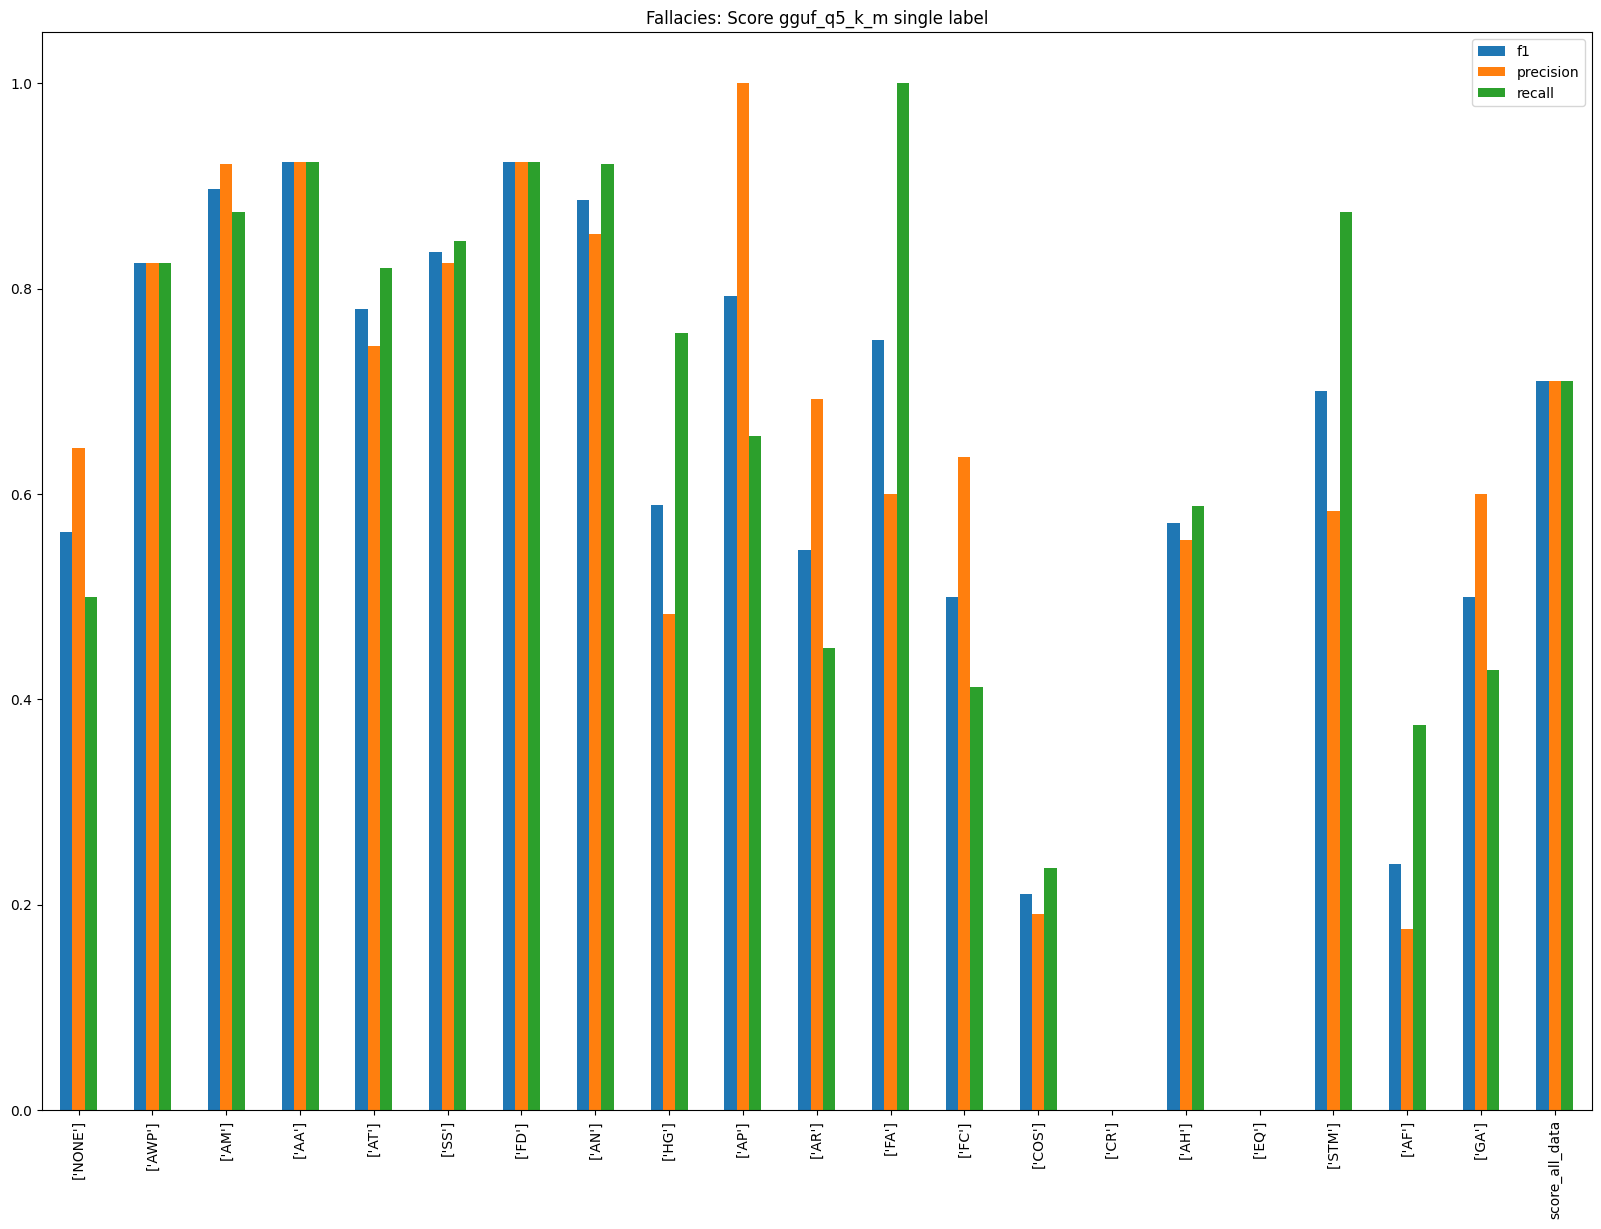

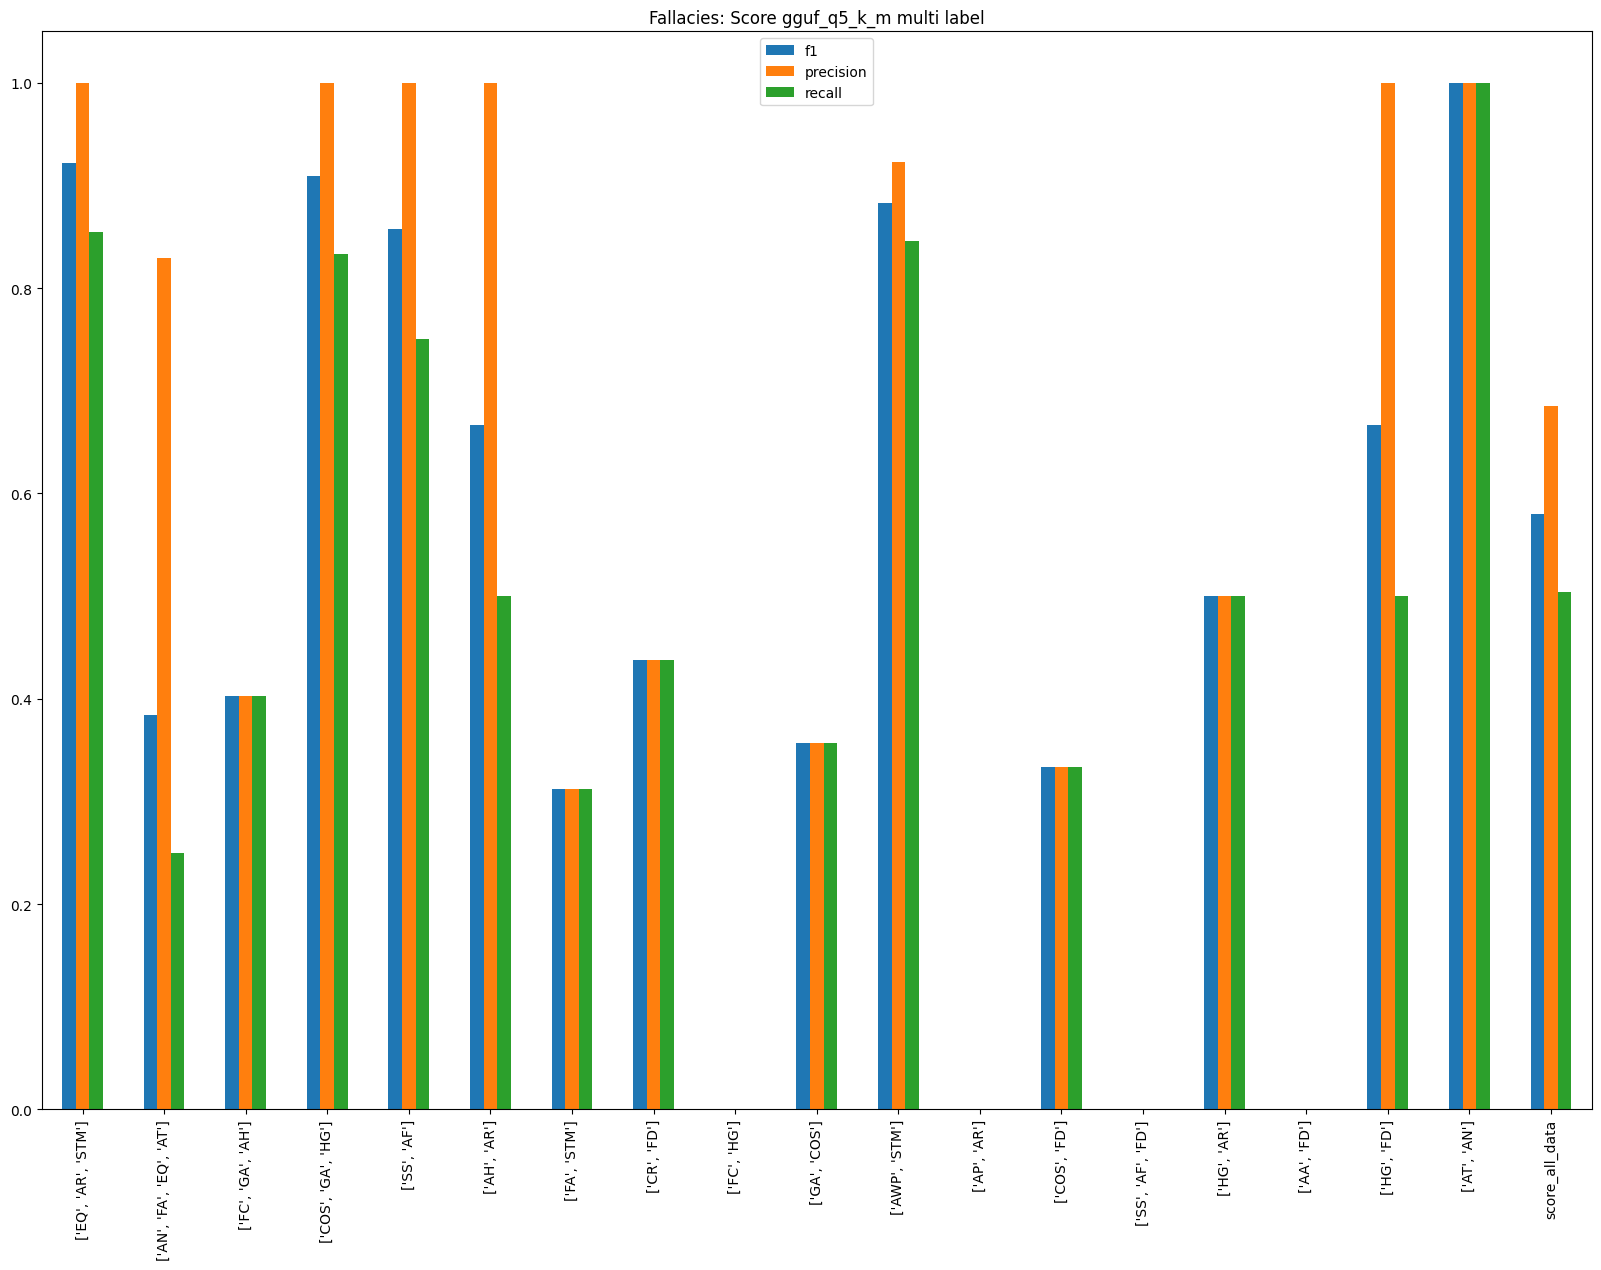

In [19]:
from src.fallacies import change_lbl
from src.metrics import get_metrics
from src.plot import plot_metric

metric_single, metric_multi = get_metrics(change_lbl, df_res)
plot_metric(
    metric=metric_single,
    title=f'Fallacies: Score gguf_{quant} single label',
    file_plot=f'./img/{task}/test_gguf_{quant}_metric_single.png',
    file_metric=f'./test_res/{task}/test_gguf_{quant}_metric_single.csv'
)
plot_metric(
    metric=metric_multi,
    title=f'Fallacies: Score gguf_{quant} multi label',
    file_plot=f'./img/{task}/test_gguf_{quant}_metric_multi.png',
    file_metric=f'./test_res/{task}/test_gguf_{quant}_metric_multi.csv'
)

In [ ]:
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.
# paths = {
#     'cocolofa': './Data_jsonl/cocolofa.jsonl',
#     'mafalda': './Data_jsonl/mafalda.jsonl'
# }
# SYSTEM_PROMPT = 'You are an expert in argumentation. Your task is to determine the type of fallacy in the given [SENTENCE]. The fallacy would be in the [FALLACY] Set. Utilize the [TITLE] and the [FULL TEXT] as context to support your decision.\nYour answer must be in the following format with only the fallacy in the answer section:\n<|ANSWER|><answer><|ANSWER|>.'
# n_sample = 4000
# e = 1.5
# n_eval = 8
# n_eval_step = np.floor((n_sample / 32) / n_eval)

# model_name = 'Llama3.18BInstruct'
# spl_name = 'spl2'
# task_name = 'fallacies'
# train_resp = '_train_resp'

# train_spl_file = f'./sampling/sample/{task_name}/{spl_name}_train.csv'
# val_spl_file = f'./sampling/sample/{task_name}/{spl_name}_val.csv'
# test_spl_file = f'./sampling/sample/{task_name}/{spl_name}_test.csv'

# outputs_dir = f'./outputs/{task_name}/{model_name}_{e}e{n_sample}{spl_name}{train_resp}'

# test_result_file = f'./test_res/{task_name}/test_res_{model_name}_{e}e{n_sample}{spl_name}{train_resp}.csv'
# result_file = f'./test_res/{task_name}/test_res_{model_name}_{e}e{n_sample}{spl_name}{train_resp}.csv'

# file_stat_train = f'./img/{task_name}/{model_name}_{e}e{n_sample}{spl_name}_stat_train.png'
# file_stat_val = f'./img/{task_name}/{model_name}_{e}e{n_sample}{spl_name}_stat_val.png'
# file_stat_test = f'./img/{task_name}/{model_name}_{e}e{n_sample}{spl_name}_stat_test.png'

# file_plot_single = f'./img/{task_name}/{model_name}_{e}e{n_sample}{spl_name}{train_resp}_res_single.png'
# file_plot_multi = f'./img/{task_name}/{model_name}_{e}e{n_sample}{spl_name}{train_resp}_res_multi.png'

# file_metric_single = f'./test_res/{task_name}/{model_name}_{e}e{n_sample}{spl_name}{train_resp}_metric_single.csv'
# file_metric_multi = f'./test_res/{task_name}/{model_name}_{e}e{n_sample}{spl_name}{train_resp}_metric_multi.csv'

In [ ]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name= "meta-llama/meta-Llama-3.1-8B-Instruct",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
    fast_inference=True,
    gpu_memory_utilization=0.6
)
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

In [ ]:
def formatting_prompt(tokenizer, d):
    t = d['prompt']
    texts = [tokenizer.apply_chat_template(txt, tokenize=False, add_generation_prompt=False) for txt in t]
    return { 'text': texts, }
time = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
chat_template = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{SYSTEM}<|eot_id|><|start_header_id|>user<|end_header_id|>

{INPUT}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{OUTPUT}<|eot_id|>"""
savefile = get_savefile(
    task_name='fallacies',
    spl_name='spl2',
    m_name='meta-Llama-3.1-8B-Instruct',
    n_sample=4000,
    epoch=2,
    train_resp='_train_resp',
    outputs_dir=f'./outputs/test_fallacies',
    time=time
)
fallacies, prt_train, prt_val, prt_test = get_data(savefile)
data_train, data_val, data_test = get_datasets(tokenizer, prt_train, prt_val, prt_test)
prt_train = prt_train.rename(columns={"prompt": "conversations"})
train = apply_chat_template(
    Dataset.from_pandas(prt_train),
    tokenizer,
    chat_template
)
tokenizer = get_chat_template(
    tokenizer,
    chat_template='llama-3.1'
)
d_train = Dataset.from_pandas(prt_train).map(
    lambda x: formatting_prompt(tokenizer, x),
    batched=True
)


In [ ]:
data, fallacies = load_all_dataset(paths)
# spl_data = get_all_spl(data, fallacies, n_sample)
# prt_train, prt_val, prt_test = get_prt(spl_data, fallacies, SYSTEM_PROMPT)

# prt_train.to_csv(train_spl_file, index=False)
# prt_val.to_csv(val_spl_file, index=False)
# prt_test.to_csv(test_spl_file, index=False)


In [ ]:
converter = {'prompt': literal_eval, 'answer': literal_eval}
prt_train = pd.read_csv(
    train_spl_file,
    converters=converter
)
prt_val = pd.read_csv(
    val_spl_file,
    converters=converter
)
prt_test = pd.read_csv(
    test_spl_file,
    converters=converter
)

In [ ]:
def formatting_prompt(data: dict):
    text = tokenizer.apply_chat_template(data.get('prompt'),tokenize = False, add_generation_prompt = False)
    return { 'text': text, }

SAMPLING_PARAMS = SamplingParams(
    temperature = 0.8,
    top_p = 0.95,
    max_tokens = 128,
)
data_train = Dataset.from_pandas(prt_train).map(
    formatting_prompt,
    batched=True,
)
data_val = Dataset.from_pandas(prt_val).map(
    formatting_prompt,
    batched=True,
)
data_test = Dataset.from_pandas(prt_test).map(
    formatting_prompt,
    batched=True
).shuffle(seed=0)

In [ ]:
# def gen(txt, model, sampling_params):
#     output = model.fast_generate(
#         txt,
#         sampling_params = sampling_params,
#     )[0].outputs[0].text
    
#     return output

# def format_output(answer: str, fallacies: set) -> list:
#     s = '<[|]ANSWER[|]>'
#     tmp = re.split(s, answer)
#     pred= [i for i in tmp if i in fallacies]
#     return pred

# def zero_shot_gen(data: list[str], model, fallacies: set, sampling_params) -> list:
#     res = []
#     for i in data:
#         out = gen(i, model, sampling_params)
#         pred = format_output(out, fallacies)
#         res.append(pred)
#     return res

In [ ]:
def gen(p, model, text_streamer):
    txt = tokenizer.apply_chat_template(
        p,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to('cuda')
    output = model.generate(
        txt,
        streamer=text_streamer,
        max_new_tokens=128,
        pad_token_id=tokenizer.eos_token_id
    )
    return output

def format_output(answer: list, labels: set) -> list:
    s = '<[|]ANSWER[|]>'
    tmp = re.split(s, answer[0])
    pred = [i for i in tmp if i in labels]
    return pred

def zero_shot_gen(
    data:Dataset,
    model,
    labels:set,
    text_streamer: TextStreamer
) -> list:
    res= []
    prompt = data['prompt']
    for prt in prompt:
        out = gen(prt, model, text_streamer)
        decoded_out = tokenizer.batch_decode(out)
        pred = format_output(decoded_out, labels)
        res.append(pred)
    return res

In [ ]:
# class custom_validation_callback(TrainerCallback):
#     def __init__(self, data, sampling_params, fallacies, n_step=10):
#         super().__init__()
#         self.val_dataset = data
#         self.sampling_params = sampling_params
#         self.fallacies = fallacies
#         self.n_step=n_step
#     def on_step_end(self, args, state, control, **kwargs):
#         if state.global_step % self.n_step == 0 and state.global_step > 0 :
#             model.save_lora('sft_save_lora')
#             FastLanguageModel.for_inference(model)
#             pred = zero_shot_gen(
#                 data=self.val_dataset['text'],
#                 model=model,
#                 fallacies=self.fallacies,
#                 sampling_params=self.sampling_params
#             )
#             tmp_pred = [i if i != [] else ['Failed'] for i in pred]
#             d = pd.DataFrame().from_records(tmp_pred)
#             d['truth_label'] = self.val_dataset['answer']
#             d['step'] = np.full((len(d['truth_label']),), state.global_step)
#             try:
#                 d.to_csv(
#                     './validation_res.csv',
#                     index=False,
#                     mode='a',
#                     header=['pred', 'truth_label', 'step']
#                 )
#             except FileNotFoundError:
#                 d.to_csv('./validation_res.csv', index=False, header=['pred', 'truth_label'])
#         return super().on_step_end(args, state, control, **kwargs)

# class custom_test_callback(TrainerCallback):
#     def __init__(self, data, sampling_params, fallacies):
#         super().__init__()
#         self.test_dataset = data
#         self.sampling_params = sampling_params
#         self.fallacies = fallacies
#     def on_train_end(self, args, state, control, **kwargs):
#         model.save_lora('sft_save_lora')
#         FastLanguageModel.for_inference(model)
#         pred = zero_shot_gen(
#             data=self.test_dataset['text'],
#             model=model,
#             fallacies=self.fallacies,
#             sampling_params=self.sampling_params
#         )
#         tmp_pred = [i if i != [] else ['Failed'] for i in pred]
#         d = pd.DataFrame().from_records(tmp_pred)
#         d['truth_label'] = self.test_dataset['answer']
#         try:
#             d.to_csv('./test_res.csv', index=False, mode='a', header=['pred','truth_label'])
#         except FileNotFoundError:
#             d.to_csv('./test_res.csv', index=False, header=['pred', 'truth_label'])
#         return super().on_train_end(args, state, control, **kwargs)

In [ ]:
training_args = TrainingArguments(
    per_device_train_batch_size = 4, #2
    per_device_eval_batch_size= 4,
    gradient_accumulation_steps = 8, #4
    eval_accumulation_steps= 8,
    warmup_steps = 5,
    num_train_epochs = e, # Set this for 1 full training run.
    # max_steps = 60,
    learning_rate = 2e-4,
    fp16 = not is_bfloat16_supported(),
    bf16 = is_bfloat16_supported(),
    logging_steps = 1,
    optim = "adamw_8bit",
    weight_decay = 0.01,
    lr_scheduler_type = "linear",
    seed = 3407,
    output_dir = outputs_dir,
    report_to = "tensorboard", # Use this for WandB etc
    eval_strategy="steps",
    eval_steps=n_eval_step,
)   
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = data_train,
    eval_dataset=data_val,
    # formatting_func=formatting_prompt,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = training_args,
)
# trainer.get_train_dataloader().shuffle = False
# trainer.get_eval_dataloader().shuffle = False
# trainer.train()
if train_resp == '_train_resp':
    trainer = train_on_responses_only(
        trainer,
        instruction_part="<|start_header_id|>user<|end_header_id|>\n\n",
        response_part="<|start_header_id|>assistant<|end_header_id|>\n\n"
    )
unsloth_train(trainer)

In [ ]:
def get_precision_recall(data):
    try:
        tmp = data.apply(
            lambda x: x['pred'] in x['lbl'],
            axis=1
        )
        tp = tmp.value_counts().loc[True]
        score = tp / len(tmp)
        fp_fn = len(tmp) - tp
        return score, tp, fp_fn
    except (KeyError, ZeroDivisionError):
        tp = 0
        score = 0
        fp_fn = len(tmp) - tp
        return score, tp, fp_fn

def get_recall_multi(data, label):
    n_lbl = len(label)
    ratio = []
    for l in label:
        c = data['pred'].value_counts()
        try:
            ratio.append(min((1/n_lbl) * (c[l] / (len(data)/n_lbl)), 1/n_lbl))
        except:
            ratio.append(min((1/n_lbl) * (0 / (len(data)/n_lbl)), 1/n_lbl))
    rec = sum(ratio)
    tp = np.round(len(data)*rec)
    fn = len(data) - tp
    return rec, tp, fn

def get_f1(precision, recall):
    try:
        f1 = 2 * ((precision * recall) / (precision + recall))
    except ZeroDivisionError:
        f1 = 0
    return f1

def get_metrics_single(data, labels):
    tp_preci = 0
    tp_rec = 0
    fn = 0
    fp = 0
    res = {}
    for l in labels:
        df_on_pred = data[data['pred'] == l[0]]
        df_on_label = data.apply(
            lambda x: x if l[0] in x['lbl'] else np.nan,
            result_type='broadcast',
            axis = 1
        ).dropna()
        precision, tp_p, fp_p = get_precision_recall(df_on_pred)
        recall, tp_r, fn_r = get_precision_recall(df_on_label)
        f1 = get_f1(precision, recall)
        n_lbl = change_lbl(l)
        res.update({str(n_lbl): (f1, precision, recall)})
        fn += fn_r
        fp += fp_p
        tp_preci += tp_p
        tp_rec += tp_r
    precision_all_data = tp_preci / (tp_preci + fp)
    recall_all_data = tp_rec / (tp_rec + fn)
    f1_all_data = get_f1(precision_all_data, recall_all_data)
    res.update({
        'score_all_data': (f1_all_data, precision_all_data, recall_all_data)
    })
    return res

def get_metrics_multi(data, labels):
    tp_preci = 0
    tp_rec = 0
    fn = 0
    fp = 0
    res = {}
    for l in labels:
        df_pred_lbl = data.apply(
            lambda x: x if x['lbl'] == l else np.nan,
            result_type='broadcast',
            axis=1
        ).dropna()
        precision, tp_p, fp_p = get_precision_recall(df_pred_lbl)
        recall, tp_r, fn_r = get_recall_multi(df_pred_lbl, l)
        f1 = get_f1(precision, recall)
        n_lbl = change_lbl(l)
        res.update({str(n_lbl): (f1, precision, recall)})
        fn += fn_r
        fp += fp_p
        tp_preci += tp_p
        tp_rec += tp_r
    precision_all_data = tp_preci / (tp_preci + fp)
    recall_all_data = tp_rec / (tp_rec + fn)
    f1_all_data = get_f1(precision_all_data, recall_all_data)
    res.update({
        'score_all_data': (f1_all_data, precision_all_data, recall_all_data)
    })
    return res

def change_lbl(labels: list) -> list:
    new_lbl = []
    replace_lbl = {
        'appeal to nature': 'AN',
        'straw man': 'STM',
        'false dilemma': 'FD',
        'appeal to tradition': 'AT',
        'causal oversimplification': 'COS',
        'appeal to majority': 'AM',
        'ad hominem': 'AH',
        'appeal to ridicule': 'AR',
        'circular reasoning': 'CR',
        'false analogy': 'FA',
        'false causality': 'FC',
        'appeal to fear': 'AF',
        'appeal to worse problems': 'AWP',
        'none': 'NONE',
        'guilt by association': 'GA',
        'equivocation': 'EQ',
        'appeal to authority': 'AA',
        'hasty generalization': 'HG',
        'slippery slope': 'SS',
        'ad populum': 'AP'
    }
    for l in labels:
        new_lbl.append(replace_lbl.get(l))
    return new_lbl
    

def get_metrics(data_single: pd.DataFrame, data_multi: pd.DataFrame):
    labels_single = data_single['lbl'].value_counts().index
    labels_multi = data_multi['lbl'].value_counts().index
    scores_single = get_metrics_single(data_single, labels_single)
    scores_multi = get_metrics_multi(data_multi, labels_multi)
    return scores_single, scores_multi

In [ ]:
FastLanguageModel.for_inference(model)
text_streamer = TextStreamer(tokenizer)

pred = zero_shot_gen(
    data=data_test,
    model=model,
    labels=fallacies,
    text_streamer=text_streamer
)

names_dataset = data_test['datasets']
true_labels = data_test['answer']

tmp_pred = [i if i != [] else ['Failed'] for i in pred]
pred_flat = list(itertools.chain.from_iterable(tmp_pred))

d_res = {'names': names_dataset, 'pred': pred_flat, 'lbl': true_labels}
df_res = pd.DataFrame(data=d_res)
df_res.to_csv(test_result_file, index=False)
# df_res = pd.read_csv(
#     result_file,
#     converters={'lbl': literal_eval}
# )
#metric = get_metrics(df_res, fallacies)
df_single = df_res.apply(
    lambda x: x if len(x['lbl']) <= 1 else np.nan,
    axis=1,
    result_type='broadcast'
).dropna()
df_multi = df_res.apply(
    lambda x: x if len(x['lbl']) > 1 else np.nan,
    axis=1,
    result_type='broadcast',
).dropna()
metric_single, metric_multi = get_metrics(df_single, df_multi)

In [ ]:
def plot_stat_sample(
    sample: pd.DataFrame,
    lst_labels: set,
    title: str,
    savefile=None,
) -> None:
    width = 0.3
    fig, ax = plt.subplots()
    d = {}
    spl_len = {}
    spl_over = {}
    under = []
    over = []
    x = np.arange(len(lst_labels))
    b = 0
    bar_label = True
    dataset_names = sample['datasets'].value_counts().index.to_list()
    for name in dataset_names:
        spl_dataset = sample[sample['datasets'] == name]
        spl = spl_dataset[spl_dataset['spl'] == 'sample']
        over_spl = spl_dataset[spl_dataset['spl'] == 'oversample']
        len_s = {
            lbl: len(spl[spl['single_ans'] == lbl])
            for lbl in lst_labels
        }
            
        len_o = {
            lbl: len(over_spl[over_spl['single_ans'] == lbl])
            for lbl in lst_labels
        }
        spl_len.update({name: len_s})
        spl_over.update({name: len_o})
    df_spl_len = pd.DataFrame().from_dict(spl_len) # .sort_index()
    df_oversample = pd.DataFrame().from_dict(spl_over) # .sort_index()
    df_spl_len.index = change_lbl(df_spl_len.index)
    df_oversample.index = change_lbl(df_oversample.index)
    df_spl_len = df_spl_len.sort_index()
    df_oversample = df_oversample.sort_index()
    for name in dataset_names:
        under.append((name, df_spl_len[name]))
        over.append((name,df_oversample[name]))
    d.update({
        'under': under,
        'over': over,
    })
    for _,v in d.items():
        if bar_label:
            lbl = 'sample'
        else:
            lbl = 'oversample'
        p = ax.bar(x, v[0][1], width, label=f'{lbl} {v[0][0]}', bottom=b)
        # ax.bar_label(p, label_type='center')
        p = ax.bar(
            x=x,
            height=v[1][1],
            width=width,
            label=f'{lbl} {v[1][0]}',
            bottom=b + v[0][1]
        )
        # ax.bar_label(p, label_type='center')
        bar_label=False
        b = b + v[0][1] + v[1][1]
    # ax.set_yticks(np.arange(0, max(df_spl_len.max().values) + 2, step=1))
    lst_labels = change_lbl(lst_labels)
    ax.set_xticks(x, sorted(lst_labels), rotation=90)
    ax.legend(loc='best')
    ax.set_title(title)
    fig.set_size_inches(20, 10)
    # plt.ylim(0, max(df_spl_len.max().values) + 1)
    plt.show()
    if savefile is not None:
        fig.savefig(savefile, format='png')

def plot_metric(
    metric: dict,
    columns: list[str]=['f1', 'precision', 'recall'],
    title='',
    file_plot=None,
    file_metric=None,
):
    # rand_mark = pd.Series(np.full((len(metric),), 1/(len(metric)-1)))
    df_metric = pd.DataFrame().from_dict(
        metric,
        orient='index',
        columns=columns
    )
    fig, ax = plt.subplots(1, 1)
    df_metric.plot(
        ax=ax,
        kind='bar',
        figsize=(20,14),
        title=title,
    )
    # rand_mark.plot(ax=ax, color='red', linestyle='dashed')
    # ax.set_yticks(np.arange(0, 1.1, step=0.05))
    plt.xticks(rotation=90)
    plt.show()
    if file_plot is not None:
        fig.savefig(file_plot, format='png')
    if file_metric is not None:
        df_metric.to_csv(file_metric, header=['F1', 'Precision', 'Recall'])

In [ ]:
# columns = ['f1', 'precision', 'recall']

# plot_stat_sample(
#     sample=prt_train,
#     lst_labels=fallacies, 
#     savefile=file_stat_train,
#     title=f'sample {spl_name} train'
# )
# plot_stat_sample(
#     sample=prt_val,
#     lst_labels=fallacies,
#     savefile=file_stat_val,
#     title=f'sample {spl_name} val'
# )
# plot_stat_sample(
#     sample=prt_test,
#     lst_labels=fallacies,
#     savefile=file_stat_test,
#     title=f'sample {spl_name} test'
# )

In [ ]:
plot_metric(
    metric=metric_single,
    title=f'Scores {n_sample} sample single fallacies',
    file_plot=file_plot_single,
    file_metric=file_metric_single
)
plot_metric(
    metric=metric_multi,
    title=f'Scores {n_sample} sample multi fallacies',
    file_plot=file_plot_multi,
    file_metric=file_metric_multi
)